In [1]:
from astropy.io import fits
import matplotlib.pyplot as plt
import numpy as np
from scipy.constants import h,c,k
from scipy.optimize import curve_fit
from scipy.interpolate import interp1d

The following files contain data from the ```COBE-FIRAS``` instrument. This data is of the form:

* **Galactic Coordinates of the part of sky** : The sky here is divided into $6144$ pixels of which $6067$ (~$95$%) pixels are retrieved with sufficient measurements.

* **The Intensity of radiation recieved at that pixel** : There are $182$ values of Intensities measured in MJy/sr, across a set of frequencies. This analysis only considers data in the low-frequency band ($60-630$ GHz)   

In [2]:
data = fits.open('FIRAS_DESTRIPED_SKY_SPECTRA_LOWF.FITS')  
lowdust_data = fits.open("FIRAS_DUST_SPECTRUM_MAP_LOWF.FITS")

In [ ]:
#error for intensity is the C vector file

# Contents of the dataset

In [6]:
destriped_data=data[1].data
dust_data = lowdust_data[1].data
destriped_data.columns
destriped_data.columns

ColDefs(
    name = 'PIXEL'; format = '1J'
    name = 'GAL_LON'; format = '1E'; unit = 'deg'
    name = 'GAL_LAT'; format = '1E'; unit = 'deg'
    name = 'WEIGHT'; format = '1E'
    name = 'STR_USED'; format = '1I'
    name = 'SPECTRUM'; format = '182E'; unit = 'MJy/sr'; dim = '(182)'
)

# Getting best fit temperatures for every pixel

It is observed that all the pixels have $43$ workable intensity values. The data is fitted to a Planck Distribution spectrum $$ I(v,T) = \frac{2hv^3}{c^2(e^{\frac{hv}{kT}}-1)} $$

In [ ]:
def Intensity(freq,T):
    
    e=np.exp(h*freq/(k*T))
    return (2*h*freq**3)/(c**2*(e-1))*1e20  # 1e20 used to convert the units
    
'''  h = planck constant
    k = boltzmann constant
    c = speed of light in vacuum
    T = temperature of blackbody
    wave_num = wave number of the radiation (1/wavelength)'''

In the following function, ```scipy.optimize.curve_fit()``` is used to find best fit parameter (Temperature of the Planck Distribution) using advanced Linear Regression algorithms

In [6]:

def get_Temperature(frequency,input): # function to get best fit temperatures and uncertainties
    
    Pixel_data=dict()
    Pixel_data['Temperature']=[]
    Pixel_data['Uncertainty']=[]
    
    for i in range(len(input)):
    
        Intensity_observed=input[i]
        Intensity_observed=Intensity_observed[0:43:]
        
        T0=2
        popt,pcov=curve_fit(Intensity,frequency,Intensity_observed,p0=[T0])
        
        Temperature_fit=popt[0]
        Uncertainty_fit=np.sqrt(np.diag(pcov))
        Pixel_data['Temperature'].append(Temperature_fit)
        Pixel_data['Uncertainty'].append(Uncertainty_fit)
    
    return Pixel_data


In [7]:
def root_mean_square(input): # function to find rms of the data
    
    input=np.array(input)
    squared_input=input**2
    mean=np.mean(squared_input)

    return np.sqrt(mean)

In [8]:
# 1st frequency is 68.020812 Ghz
freq_0=68.020812*1e9
freq_interval=13.604162*1e9
#wave number is freq/c. there are 43 total values measured with this interval

frequency=[]
for i in range(43):
    freq_flag=freq_0+i*freq_interval
    frequency.append(freq_flag)
frequency=np.array(frequency)

 we will use either this or the ```Pixel_data['Uncertainty']``` data, though i suppose we should use this because this method produces a little bit larger range of uncertainty

In [9]:
def uncertainty(input,mean):
    uncertainty_list =[]
    
    for i in range(len(input)):
    
        if input[i] > mean:
          uncertainty_list.append(input[i] - mean) 
    
        else:
          uncertainty_list.append(mean - input[i])
    
    uncertainty_array = np.array(uncertainty_list)
    
    return(np.mean(uncertainty_array))

```Pixel_data``` is a dictionary in which temperatures and uncertainties are mapped to each other more all 6067 pixels

In [10]:
Pixel_data=get_Temperature(frequency,destriped_data['SPECTRUM'])

Calculating the arithmetic mean/root mean square of the temperatures found will give us the Average CMB temperature

In [11]:
avg_temperature = np.mean(Pixel_data['Temperature'])
avg_uncertainty = uncertainty(Pixel_data['Temperature'] , avg_temperature)  

root_mean_square_temperature = root_mean_square(Pixel_data['Temperature'])
standard_deviation_temperature = np.std(Pixel_data['Temperature'])

print('T in terms of arithmetic means(Averages) = {:.6f} +- {:.6f} K'.format(avg_temperature , avg_uncertainty))
print('T in terms of root mean square values = {:.6f} +- {:.6f} K'.format(root_mean_square_temperature , standard_deviation_temperature))


T in terms of arithmetic means(Averages) = 2.729850 +- 0.002725 K
T in terms of root mean square values = 2.729854 +- 0.004647 K


# Plotting the Temperatures

It's important to convert the galactic longitudes of the form ( $0$ - $360$ ) into the conventional form ( $-180$ - $+180$ )

In [12]:
longitude=[]

for i in destriped_data['GAL_LON']:
    if i > 180:
        
        longitude.append(i-360)
    else:
        
        longitude.append(i)

[61.182686, 63.731583, 59.82832, 62.99902, 65.06563, 69.33622, 65.52773, 66.95183, 59.092663, 61.895866, 58.089657, 61.276062, 65.105415, 67.34067, 63.91097, 67.165924, 71.45478, 72.68808, 70.79812, 72.76944, 75.623825, 78.65012, 75.2739, 76.88742, 68.878365, 72.42117, 69.21635, 71.16124, 74.94508, 77.242966, 74.955246, 76.29343, 57.63955, 60.348667, 57.34099, 59.974045, 63.416832, 66.13665, 62.763054, 65.51468, 56.819794, 59.493023, 59.125954, 62.16967, 64.76709, 61.829876, 64.41439, 69.164246, 71.1994, 68.06115, 71.08058, 77.6587, 73.05655, 76.85439, 67.77791, 70.32067, 67.02467, 70.00706, 73.21137, 75.19506, 72.43586, 75.32275, 80.06729, 81.908875, 80.14608, 82.15777, 84.66946, 86.85611, 84.293915, 86.43872, 80.50403, 81.71258, 79.16601, 81.6672, 83.98569, 86.414505, 84.35181, 86.357254, 88.93221, 91.25287, 88.71877, 91.02275, 93.008095, 95.33632, 92.974815, 95.28496, 88.71705, 90.84803, 88.546555, 90.84213, 93.14081, 95.30349, 93.158615, 95.19446, 78.28917, 79.00169, 81.18493, 84.9

Degree to radian conversions

In [13]:
latitude_rad = np.pi * destriped_data['GAL_LAT']/180
longitude_rad = np.pi * np.array(longitude)/180

Plotting the temperature map on an equal area 'aitoff' projection

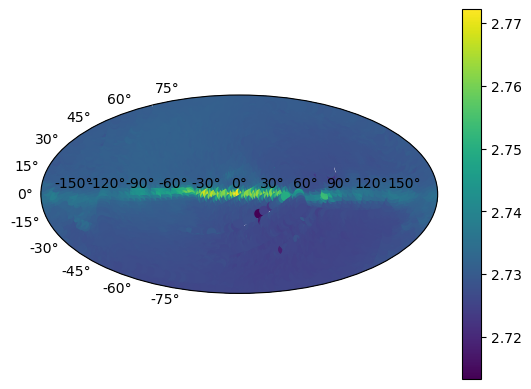

In [14]:
plt.figure()
plt.subplot(111,projection='aitoff')
#plt.scatter(longitude_rad,latitude_rad,c=Pixel_data['Temperature'],cmap='plasma',norm=LogNorm(vmax=np.nanmax(Pixel_data['Temperature'])))
plt.scatter(longitude_rad,latitude_rad,c = np.array(Pixel_data['Temperature']))
plt.colorbar()

It is inferred that the all-sky spectrum recieved alone does not accurately represen the Microwave Background. So, we use a multitude of techniques to filter the data, trying to gather the best result possible.

In [1]:
a='DUST SPECTRUM REMOVAL- THE DESTRIPED DATA WHICH WE USE IS HIGHLY CONTAMINATED ,THE ABSOLUTE INTENSITIES ARE DISRUPTED BY THE EMISSION OF EM RADIATION DUE TO MANY GALACTIC AND OTHER ENTITIES ,A MAJOR SET OF ENTITIES OF THAT SORT IS THE COSMIC DUST . OUR GOAL IS TO REMOVE ALL THE DUST COMPONENTS FROM THE DESTRIPED SKY SPECTRA '
a.lower()

'dust spectrum removal- the destriped data which we use is highly contaminated ,the absolute intensities are disrupted by the emission of em radiation due to many galactic and other entities ,a major set of entities of that sort is the cosmic dust . our goal is to remove all the dust components from the destriped sky spectra '

# 1. Cosmic Dust removal 

The destriped data which we used is highly contaminated ,the absolute intensities are disrupted by the emission of EM radiation due to many galactic and other entities ,a major set of entities of that sort is the cosmic dust . our goal is to remove all the dust components from the destriped sky spectra

In [15]:
def get_values(input_data):
    values=np.zeros(4)
    values[0]=avg_temperature=np.mean(input_data)
    values[1]=avg_uncertainty=uncertainty(input_data,avg_temperature)
    values[2]=root_mean_square_temperature = root_mean_square(input_data)
    values[3]=standard_deviation_temperature = np.std(input_data)

    return values

Just like `destriped_data` we received the cosmic dust spectrum from the Lambda website

In [16]:
final_data = [i*0 for i in range(0,6067)]

dust_clear_data = destriped_data['SPECTRUM'] -dust_data['SPECTRUM']

for i in range(len(dust_clear_data)):
    final_data[i] = dust_clear_data[i][:43:] + final_data[i]

Pixel_data=get_Temperature(frequency,final_data)

    
vals=get_values(Pixel_data['Temperature'])

print('Arithmetic mean temperature(Average temperature) = {:.6f} +- {:.6f} K'.format(vals[0],vals[1]))
print('Root mean square temperature = {:.6f} +- {:.6f} K'.format(vals[2],vals[3]))

Arithmetic mean temperature(Average temperature) = 2.727816 +- 0.001683 K
Root mean square temperature = 2.727816 +- 0.001948 K
6067


As a control setup we also work on the data with no dust removal side by side with the one with removed dust so as to compare the two sets of values and maps we obtain

In [17]:
final_data_control = [i*0 for i in range(0,6067)]

for i in range(len(destriped_data['SPECTRUM'])):
    final_data_control[i] = destriped_data['SPECTRUM'][i][:43:] + final_data_control[i]

Pixel_data_control = get_Temperature(frequency,final_data_control)

vals=get_values(Pixel_data_control['Temperature'])
print('Arithmetic mean temperature(Average temperature) control = {:.6f} +- {:.6f} K'.format(vals[0],vals[1]))
print('Root mean square temperature control= {:.6f} +- {:.6f} K'.format(vals[2],vals[3]))



Arithmetic mean temperature(Average temperature) control = 2.729850 +- 0.002725 K
Root mean square temperature control= 2.729854 +- 0.004647 K


# 2. Galactic cutting

The galaxy emission(em waves emitted by stars and other objects in and around the galaxy) causes our cmb temperature value to deviate as cmb is independent of the presence of any physical object in present universe which can emit em radiation hence to obtain better approximation of cmb we consider removing those pixels from our working set of pixels which have huge galactic contamination in their data.

In [18]:
'''NO NEED TO PANIC GUYS ;)  IT JUST LOOKS COMPLICATED, just keep in mind that we are working on two data sets - 
control dataset and experimental dataset'''

latitude = destriped_data['GAL_LAT']
longitude = destriped_data['GAL_LON']
Intensity_observed = final_data
Intensity_observed_control = final_data_control

i=[]
accepted_spectrum=[]
accepted_spectrum_control =[]
accepted_latitude=[]
accepted_longitude=[]


for i in range(0,len(latitude)):
    
    if latitude[i] < 20:
    
        if latitude[i] > -20:
            continue
    
        else:
            accepted_spectrum.append(Intensity_observed[i])
            accepted_spectrum_control.append(Intensity_observed_control[i])
            accepted_latitude.append(latitude[i])
            accepted_longitude.append(longitude[i])
    
    if latitude[i]> 20:
        accepted_spectrum.append(Intensity_observed[i])
        accepted_spectrum_control.append(Intensity_observed_control[i])
        accepted_latitude.append(latitude[i])
        accepted_longitude.append(longitude[i])

spectrum_cut=np.array(accepted_spectrum)
spectrum_cut_control = np.array(accepted_spectrum_control)
spectrum_cut.shape
spectrum_cut_control.shape

'just for reference. remove the hashtag to observe the respective arrays'

In [19]:
print(len(spectrum_cut))

4005


## Plotting the data

In [20]:
longitude=[]

for i in accepted_longitude:
    
    if i > 180:
        longitude.append(i-360)
    
    else:
        longitude.append(i)

accepted_latitude=np.array(accepted_latitude)
accepted_longitude=np.array(longitude)

In [21]:
# THIS SUB_CODEBLOCK IS FOR EXPERIMENTAL DATASET
Pixel_cut = get_Temperature(frequency,spectrum_cut)

vals = get_values(Pixel_cut['Temperature'])
print('Arithmetic mean temperature(Average temperature) = {:.6f} +- {:.6f} K'.format(vals[0],vals[1]))
print('Root mean square temperature = {:.6f} +- {:.6f} K'.format(vals[2],vals[3]))


'''.........................................................................................................................................................................'''


# THIS SUB-CODEBLOCK IS FOR CONTROL DATASET
Pixel_cut_control = get_Temperature(frequency,spectrum_cut_control)

vals = get_values(Pixel_cut_control['Temperature'])
print('Arithmetic mean temperature(Average temperature) = {:.6f} +- {:.6f} K'.format(vals[0],vals[1]))
print('Root mean square temperature = {:.6f} +- {:.6f} K'.format(vals[2],vals[3]))



Arithmetic mean temperature(Average temperature) = 2.727780 +- 0.001802 K
Root mean square temperature = 2.727780 +- 0.002081 K
Arithmetic mean temperature(Average temperature) = 2.728379 +- 0.001819 K
Root mean square temperature = 2.728380 +- 0.002108 K


CLEARLY CUT ALONG THE GALACTIC EQUATOR AS DONE ABOVE IS NOT ADEQUATE,THERE IS STILL DEVIATION WE WOULD LIKE TO GET RID OF.
ANY PIXEL WITH MORE THAN 5*SIGMA DEVIATION(SIGMA IS THE RMS VALUE OF FINAL TEMPERATURES COMPUTED TILL NOW) FROM THE AVERAGE SHOULD BE DROPPED FROM THE ANALYSIS


In [22]:
sigma_corrected_data=[]
sigma_corrected_uncertainty=[]
accepted_longitude.tolist()
accepted_latitude.tolist()
final_latitude = []
final_longitude = []

sigma = np.std(Pixel_cut['Temperature'])

for i in range(len(Pixel_cut['Temperature'])):
    
    point_max=avg_temperature +5*sigma
    point_min=avg_temperature -5*sigma
    
    if Pixel_cut['Temperature'][i] < point_max:
    
        if Pixel_cut['Temperature'][i]>=point_min:
            sigma_corrected_data.append(Pixel_cut['Temperature'][i])
            sigma_corrected_uncertainty.append(Pixel_cut['Uncertainty'][i][0])
            final_longitude.append(accepted_longitude[i])
            final_latitude.append(accepted_latitude[i])

sigma_corrected_data=np.array(sigma_corrected_data)


sigma_corrected_data_control=[]
final_latitude_control = []
final_longitude_control = []

sigma_control = np.std(Pixel_cut_control['Temperature'])

for i in range(len(Pixel_cut_control['Temperature'])):

    point_max=avg_temperature +5*sigma_control
    point_min=avg_temperature -5*sigma_control

    if Pixel_cut_control['Temperature'][i] < point_max:

        if Pixel_cut_control['Temperature'][i]>=point_min:

            sigma_corrected_data_control.append(Pixel_cut_control['Temperature'][i])
            final_longitude_control.append(accepted_longitude[i])
            final_latitude_control.append(accepted_latitude[i])

sigma_corrected_data_control=np.array(sigma_corrected_data_control)



TEMPERATURES ARE IN TWO FORMS ONE IS DERIVED FROM THE AVERAGE METHOD AND THE OTHER VIA ROOT MEAN SQUARE METHOD

Temperature of experimental dataset

In [23]:
vals = get_values(sigma_corrected_data)

print('Arithmetic mean temperature(Average temperature) final = {:.6f} +- {:.6f} K'.format(vals[0],vals[1]))
print('Root mean square temperature final = {:.6f} +- {:.6f} K'.format(vals[2],vals[3]))


Arithmetic mean temperature(Average temperature) final = 2.727780 +- 0.001802 K
Root mean square temperature final = 2.727780 +- 0.002081 K


Temperature of control dataset

In [24]:
vals=get_values(sigma_corrected_data_control)

print('Arithmetic mean temperature(Average temperature) control = {:.6f} +- {:.6f} K'.format(vals[0],vals[1]))
print('Root mean square temperature control = {:.6f} +- {:.6f} K'.format(vals[2],vals[3]))


Arithmetic mean temperature(Average temperature) control = 2.728384 +- 0.001814 K
Root mean square temperature control = 2.728385 +- 0.002096 K


In [25]:
rms_final=vals[2]
dipole=sigma_corrected_data - rms_final
#np.mean(sigma_corrected_data)
np.mean(dipole)

-0.0006056842071269381

THE OFFICIAL VALUE OF CMB TEMPERATURE AS PER COBE FIRAS IS 2.727754 HENCE WE CAN SUPPOSE THAT THE CODE WAS A SUCCESS :) 

These 2 codeblocks are required to attain a well approximate graph of the relation between intensities and frequencies

In [26]:
spectrum_cut_transpose = spectrum_cut.T
spectrum_cut_transpose_control = spectrum_cut_control.T

In [27]:
spectrum_cut_transpose

array([[200.831    , 200.83134  , 200.80768  , ..., 200.81892  ,
        200.78421  , 200.79214  ],
       [250.09875  , 250.1014   , 250.07742  , ..., 250.07478  ,
        250.03485  , 250.046    ],
       [293.1579   , 293.07614  , 293.09     , ..., 292.9702   ,
        293.04245  , 293.0245   ],
       ...,
       [  7.0759706,   7.0449123,   7.063032 , ...,   7.08223  ,
          7.0947213,   7.0836363],
       [  6.089243 ,   5.9081163,   5.985965 , ...,   6.0267396,
          6.0215087,   6.0160885],
       [  4.6588097,   5.0996695,   4.807772 , ...,   4.9758453,
          4.876078 ,   4.7995033]], dtype=float32)

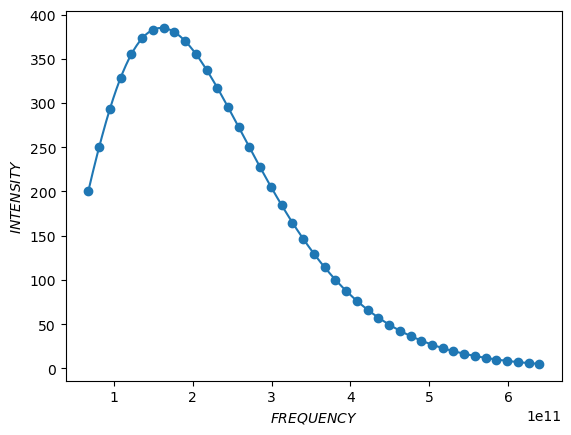

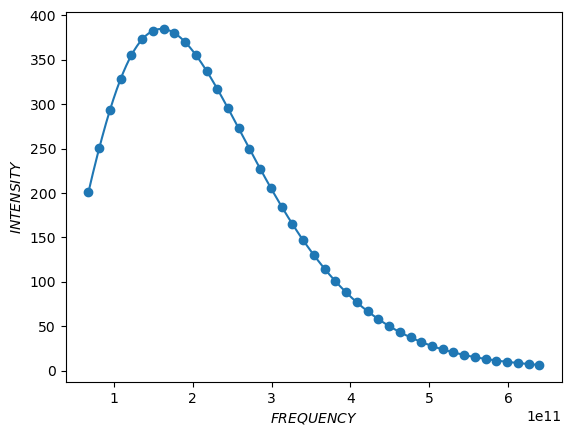

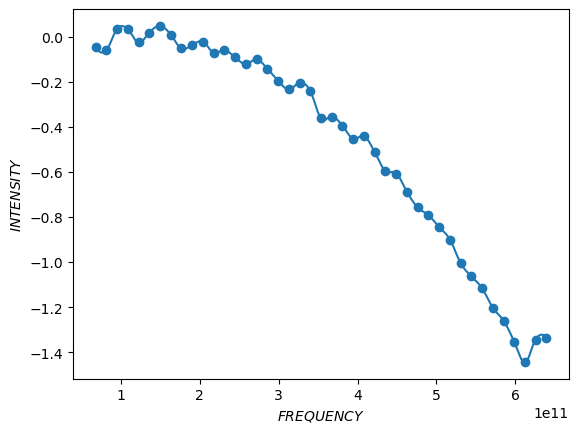

In [28]:
# this sub code block is for finding the intensity vs frequency map of experimental dataset
mean_list = [i*0 for i in range(43)]
for i in range(len(spectrum_cut_transpose)):
    mean_list[i] = np.mean(spectrum_cut_transpose[i]) + mean_list[i]    

x = np.array(frequency)
f = interp1d(frequency,mean_list,kind = 'quadratic')
x_dense = np.linspace(frequency[0],frequency[42],1000)
y_dense = f(x_dense)
plt.xlabel('$FREQUENCY$',fontsize = 10)
plt.ylabel('$INTENSITY$',fontsize = 10)
plt.scatter(frequency,mean_list)
plt.plot(x_dense,y_dense)
plt.show()


# this sub code block is for finding the intensity vs frequency map of control dataset
mean_list_control = [i*0 for i in range(43)]
for i in range(len(spectrum_cut_transpose_control)):
    mean_list_control[i] = np.mean(spectrum_cut_transpose_control[i]) + mean_list_control[i]    

x = np.array(frequency)
f_control = interp1d(frequency,mean_list_control,kind = 'quadratic')
x_dense_control = np.linspace(frequency[0],frequency[42],1000)
y_dense_control = f_control(x_dense)
plt.xlabel('$FREQUENCY$',fontsize = 10)
plt.ylabel('$INTENSITY$',fontsize = 10)
plt.scatter(frequency,mean_list_control)
plt.plot(x_dense_control,y_dense_control)
plt.show()


# this sub code block is for finding the difference between the intensity values of experimental dataset and control dataset 
mean_list_diff = [i*0 for i in range(43)]
for i in range(len(spectrum_cut_transpose_control)):
    mean_list_diff[i] = np.mean(spectrum_cut_transpose[i]) - np.mean(spectrum_cut_transpose_control[i]) + mean_list_diff[i]    

x = np.array(frequency)
f_control = interp1d(frequency,mean_list_diff,kind = 'quadratic')
x_dense_control = np.linspace(frequency[0],frequency[42],1000)
plt.xlabel('$FREQUENCY$',fontsize = 10)
plt.ylabel('$INTENSITY$',fontsize = 10)
y_dense_control = f_control(x_dense)
plt.scatter(frequency,mean_list_diff)
plt.plot(x_dense_control,y_dense_control)
plt.show()

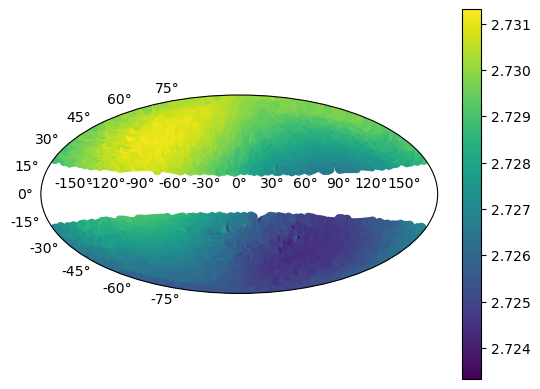

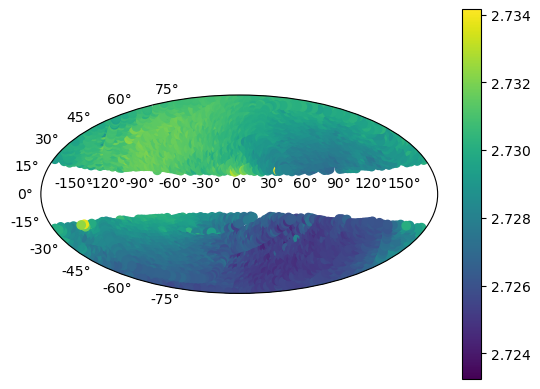

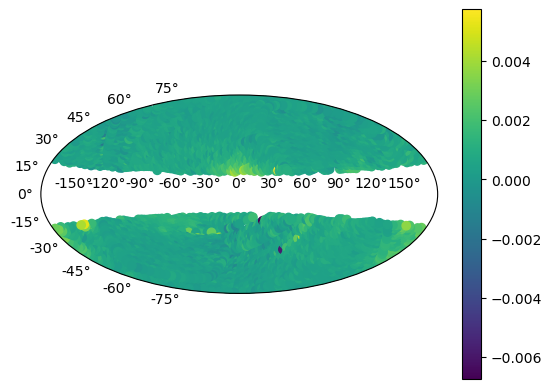

In [29]:
# This subcode_block is for the experimental dataset        DUST REMOVED SPECTRA
longitude=[]
for i in final_longitude:
    if i > 180:
        longitude.append(i-360)
    else:
        longitude.append(i)
latitude=final_latitude
latitude_rad=np.pi*np.array(final_latitude)/180
longtitude_rad=np.pi*np.array(final_longitude)/180
plt.figure()
plt.subplot(111,projection='aitoff')
plt.scatter(longtitude_rad,latitude_rad,c=sigma_corrected_data)
plt.colorbar()
'''........................................................................................................................................................................'''
# This subcode_block is for the control dataset             NO-DUST-REMOVAL 
longitude=[]
for i in final_longitude_control:
    if i > 180:
        longitude.append(i-360)
    else:
        longitude.append(i)
latitude=final_latitude_control
latitude_rad_control=np.pi*np.array(final_latitude_control)/180
longtitude_rad_control=np.pi*np.array(final_longitude_control)/180
plt.figure()
plt.subplot(111,projection='aitoff')
plt.scatter(longtitude_rad_control,latitude_rad_control,c=sigma_corrected_data_control)
plt.colorbar()
'''........................................................................................................................................................................'''
# This subcode _block is only for dust
longitude=[]
for i in final_longitude:
    if i > 180:
        longitude.append(i-360)
    else:
        longitude.append(i)
latitude=final_latitude
latitude_rad=np.pi*np.array(final_latitude)/180
longtitude_rad =np.pi*np.array(final_longitude)/180
plt.figure()
plt.subplot(111,projection='aitoff')
plt.scatter(longtitude_rad,latitude_rad,c= -np.array(Pixel_cut['Temperature'])+np.array(Pixel_cut_control['Temperature']))
plt.colorbar()

# Calculating Velocity of our Solar System

The apparant background temperature of an observer moving with a velocity v with respect to the background radiation is of the form:$$T_{obs}= T_{cmbr}\frac{\sqrt{1-(\frac{v}{c})}}{1-(\frac{v}{c})cos\theta} $$
$$= T_{cmbr}(1+\frac{v}{c}cos\theta)$$

First, we need to find the values $cos\theta$ from every pixel of the sky to the point of the highest temperature 

In [31]:
def deg_rad(deg):
    rad = np.pi * deg/180
    return rad
def costheta(l1,b1,l2,b2):
    l1=deg_rad(l1)
    b1=deg_rad(b1)
    l2=deg_rad(l2)
    b2=deg_rad(b2)
    a,b,c = np.zeros(len(l1)), np.zeros(len(l1)), np.zeros(len(l1))
    for i in range(len(l1)):
        a[i]=np.cos(b1[i])*np.cos(l1[i])*np.cos(b2)*np.cos(l2)
        b[i]=np.cos(b1[i])*np.sin(l1[i])*np.cos(b2)*np.sin(l2)
        c[i]=np.sin(b1[i])*np.sin(b2)
    return a+b+c

The highest temperature indicates from where we calculate $\theta$ from

In [33]:
dipole = dipole.tolist()
dipole.index(np.max(dipole))

2157

In [34]:
dipole_data_control = dipole_data_control.tolist()
dipole_data_control.index(np.max(dipole_data_control))

NameError: name 'dipole_data_control' is not defined

Using the coordinates of that point, the function calculates $cos\theta$ for the entire data

In [37]:
index = dipole.index(np.max(dipole))
l1 = final_longitude[index]
b1 = final_latitude[index]
cos_theta = costheta(np.array(final_longitude) , np.array(final_latitude), l1, b1)

In [ ]:
index = dipole_data_control.index(np.max(dipole_data_control))
l1 = final_longitude_control[index]
b1 = final_latitude_control[index]
costheta_control = costheta(np.array(final_longitude_control),np.array(final_latitude_control),l1,b1)

NameError: name 'dipole_data_control' is not defined

# Chi-Squared($\chi^2$) analysis

To find the velocity and it's tolerance, we turn back to a well-known data analysis technique. This is used to calculate best-fit parameters(A and B) using linear regression

$$\chi^2 = \sum{\frac{(y_i-Ax_i-B)^2}{\sigma^2_i}}$$

In [ ]:
y = Temperature
x = 2.727755*cos_theta/c
yerr = sigma

Opening the summation into the terms of the equation, we get:
$$\chi^2 = \sum{\frac{y^2_i}{\sigma^2_i}}   - 2A \sum{\frac{y_ix_i}{\sigma^2_i}}  - 2B\sum{\frac{y_i}{\sigma^2_i}} - 2AB \sum{\frac{x_i}{\sigma^2_i}} + A^2 \sum{\frac{x^2_i}{\sigma^2_i}} + B^2 \sum{\frac{1}{\sigma^2_i}}$$

To save space, we redefine those sums and rewrite as

$$\chi^2 = [S_{yy}] -2A[S_{xy}] -2B[Sy] -2AB[S_x] +A^2[S_{xx}] +B^2[S_0] $$

In [ ]:
s_yy=sum (y**2/yerr**2)
s_xx=sum(x**2/yerr**2)
s_0=sum(1/yerr**2)
s_xy=sum( (y*x) /yerr**2)
s_y=sum(y/yerr**2)
s_x=sum(x/yerr**2)

By completing the square and exchanging the six parameters(the S's) for six new parameters $A^*,\sigma_A,B^*,\sigma_B,\rho$ and $\chi^2_{min}$:

$$\chi^2 = \frac{(A-A^*)^2}{\sigma_A^2} + \frac{(B-B**)^2}{\sigma_B^2} + 2\rho\frac{(A-A^*)(B-B^*)}{\sigma_A \sigma_A} + \chi^2_{min}$$

Of course, you recognize this as the equation of an elliptic paraboloid! This means that in place of a parabola along the
A axis we now have a (bowl shaped) three-dimensional paraboloid hovering above the A-B plane. The best fit parameters A* and B* are located at the minimum point of the paraboloid, where $\chi^2=\chi^2_{min}$

In [ ]:

# by completing the square, we rewrite chi-squared as
# sum((y_i - A x_i - B)*2/sigma_i*2
# = (A-A**)*2/sigma_A*2
# + (B-B**) *2/sigma_B*2
# + 2*rho* (A-A**) (B-B**) /sigma_A*Sigma_A
# + \chi*2_{min}
A_best = (s_0*s_xy - s_x*s_y)/(s_0*s_xx - s_x**2)
sigma_A = 1/sqrt(s_xx);
B_best = (s_y*s_xx - s_x*s_xy)/(s_0*s_xx - s_x**2)
sigma_B = 1/sqrt(s_0);
rho = s_x/sqrt(s_xx*s_0);
minchi2 = (s_0*s_xy**2 - 2*s_x*s_y*s_xy + s_y**2*s_xx)/(s_x**2 - \
s_0*s_xx) + s_yy

create parameter grid


In [ ]:

A_interval = 1.1* (sqrt (6.17*sigma_A**2/(1-rho**2)));
B_interval = 1.1* (sqrt (6.17*sigma_B**2/(1-rho**2)));

# create parameter grid
a = np.linspace(A_best-A_interval, A_best+A_interval)
b = np.linspace(B_best-B_interval, B_best+B_interval)
A,B = np.meshgrid(a,b)

calculate chi-square over parameter grid


In [ ]:

# chi2=(S1)+ (A**2)*(S2) + (B**2)*(S3) - 2*A*S4 - 2*B*S5 + 2*A*B*S6
chi2 = s_yy + (A**2)*s_xx + (B**2)*s_0 - 2*A*s_xy - 2*B*s_y + 2*A*B*s_x;

plot chi-square in A-~b parameter plane with 68% and 95% contours


In [ ]:

# plot data with errorbars
'''
plt.figure (1)
plt.plot (x,A_best*x)
plt.errorbar (x,y, yerr, linestyle='None',fmt='.k')
plt.xlabel('x', fontsize=16)
plt.ylabel('y', fontsize=16)
plt.grid(True)
plt.title("y vs x data with y-error bars")
'''
plt.figure(figsize=(6,6))
levels= [minchi2,minchi2+2.3,minchi2+6]
Z=plt.contour(B,A,chi2,levels)
plt.clabel(Z,inline=1, fontsize=10)
plt.plot(B_best,A_best,'+')
plt.xlabel('$T_{cmbr}$ (intercept)',fontsize=16)
plt.ylabel('velocity ',fontsize=16)
plt.title('Chi-square 68% and 95% contours in A-B plane')
plt.show()

In [ ]:
print('Velocity of the solar system with resoect to the CMB is {:.4f} +- {:.4f} km/s (95% CL)'.format(A_best/1e3,sigma_A/1e3))